# Earthquake Trading Bot — Statistics

In [1]:
import json
import os
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

DATA_DIR = Path('trading_bot/data')
ACTIVE_DIR = DATA_DIR / 'active'
HISTORY_DIR = DATA_DIR / 'history'
SELL_ORDERS = DATA_DIR / 'sell_orders.json'

def load_positions(directory):
    positions = []
    if not directory.exists():
        return positions
    for f in directory.glob('*.json'):
        with open(f) as fh:
            positions.append(json.load(fh))
    return positions

active = load_positions(ACTIVE_DIR)
closed = load_positions(HISTORY_DIR)
all_positions = active + closed

# Load sell orders
sell_orders = {}
if SELL_ORDERS.exists():
    with open(SELL_ORDERS) as f:
        sell_orders = json.load(f)

print(f'Active positions: {len(active)}')
print(f'Closed positions: {len(closed)}')
print(f'Pending sell orders: {len(sell_orders)}')

Active positions: 28
Closed positions: 23
Pending sell orders: 29


## Open Positions

In [2]:
rows = []
for p in active:
    sell = sell_orders.get(p['id'], {})
    rows.append({
        'Market': p['market_slug'][:50],
        'Side': p['outcome'],
        'Entry': f"{p['entry_price']:.1%}",
        'Fair@Entry': f"{p['fair_price_at_entry']:.1%}",
        'Edge': f"{p['edge_at_entry']:.2%}",
        'Cost $': round(p['entry_size'], 2),
        'Tokens': round(p['tokens'], 2),
        'Sell': f"{sell['price']:.1%}" if sell else '—',
        'Time': p['entry_time'][:16],
    })

df_active = pd.DataFrame(rows).sort_values('Cost $', ascending=False)
total_invested = sum(p['entry_size'] for p in active)
print(f'Total invested: ${total_invested:.2f}\n')
df_active.style.hide(axis='index')

Total invested: $264.55



Market,Side,Entry,Fair@Entry,Edge,Cost $,Tokens,Sell,Time
how-many-7pt0-or-above-earthquakes-in-2026-5-7-YES,YES,5.3%,6.9%,2.65%,47.230000,888.990000,7.0%,2026-02-01T07:34
how-many-7pt0-or-above-earthquakes-in-2026-14-16-Y,YES,28.0%,28.4%,4.40%,38.300000,136.780000,29.0%,2026-02-02T07:36
how-many-7pt0-or-above-earthquakes-in-2026-8-10-YE,YES,20.2%,22.2%,6.16%,33.940000,167.890000,22.0%,2026-02-02T07:36
how-many-7pt0-or-above-earthquakes-in-2026-14-16-Y,YES,28.0%,28.4%,4.42%,18.710000,66.820000,29.0%,2026-02-02T03:13
how-many-7pt0-or-above-earthquakes-by-june-30-6-YE,YES,13.1%,14.8%,2.81%,14.870000,113.790000,16.0%,2026-02-02T03:13
how-many-7pt0-or-above-earthquakes-in-2026-5-7-YES,YES,6.0%,6.9%,2.67%,13.860000,230.330000,7.0%,2026-02-01T11:32
how-many-7pt0-or-above-earthquakes-in-2026-8-10-YE,YES,21.2%,22.2%,4.18%,11.840000,55.830000,22.0%,2026-02-02T09:17
how-many-7pt0-or-above-earthquakes-in-2026-5-7-YES,YES,4.1%,6.9%,2.75%,8.300000,202.550000,7.0%,2026-02-01T07:20
how-many-6pt5-or-above-earthquakes-february-2-feb-,NO,49.7%,50.8%,3.82%,8.300000,16.700000,50.0%,2026-02-02T10:56
how-many-6pt5-or-above-earthquakes-february-2-feb-,YES,13.0%,13.1%,2.09%,7.160000,55.050000,12.0%,2026-02-02T04:53


## Closed Positions (Trade History)

In [3]:
rows_closed = []
for p in closed:
    exit_size = p.get('exit_size') or 0
    entry_size = p['entry_size']
    status = p.get('status', 'closed')
    if status == 'win':
        pnl = p['tokens'] - entry_size
    elif status == 'loss':
        pnl = -entry_size
    else:
        pnl = exit_size - entry_size
    rows_closed.append({
        'Market': p['market_slug'][:50],
        'Side': p['outcome'],
        'Entry': f"{p['entry_price']:.1%}",
        'Exit': f"{p.get('exit_price', 0):.1%}" if p.get('exit_price') else status,
        'Cost $': round(entry_size, 2),
        'Return $': round(exit_size, 2) if exit_size else '—',
        'P&L $': round(pnl, 2),
        'P&L %': f"{pnl/entry_size:.1%}" if entry_size > 0 else '—',
        'Opened': p['entry_time'][:16],
        'Closed': (p.get('exit_time') or '')[:16],
        'Status': status,
    })

if rows_closed:
    df_closed = pd.DataFrame(rows_closed).sort_values('Closed', ascending=False)
    total_pnl = sum(r['P&L $'] for r in rows_closed)
    wins = sum(1 for r in rows_closed if r['P&L $'] > 0)
    losses = sum(1 for r in rows_closed if r['P&L $'] <= 0)
    print(f'Realized P&L: ${total_pnl:.2f}  |  Wins: {wins}  |  Losses: {losses}  |  Win rate: {wins/(wins+losses):.0%}\n')
    df_closed.style.hide(axis='index')
else:
    print('No closed positions yet')

Realized P&L: $-2.46  |  Wins: 11  |  Losses: 12  |  Win rate: 48%



## Portfolio Overview

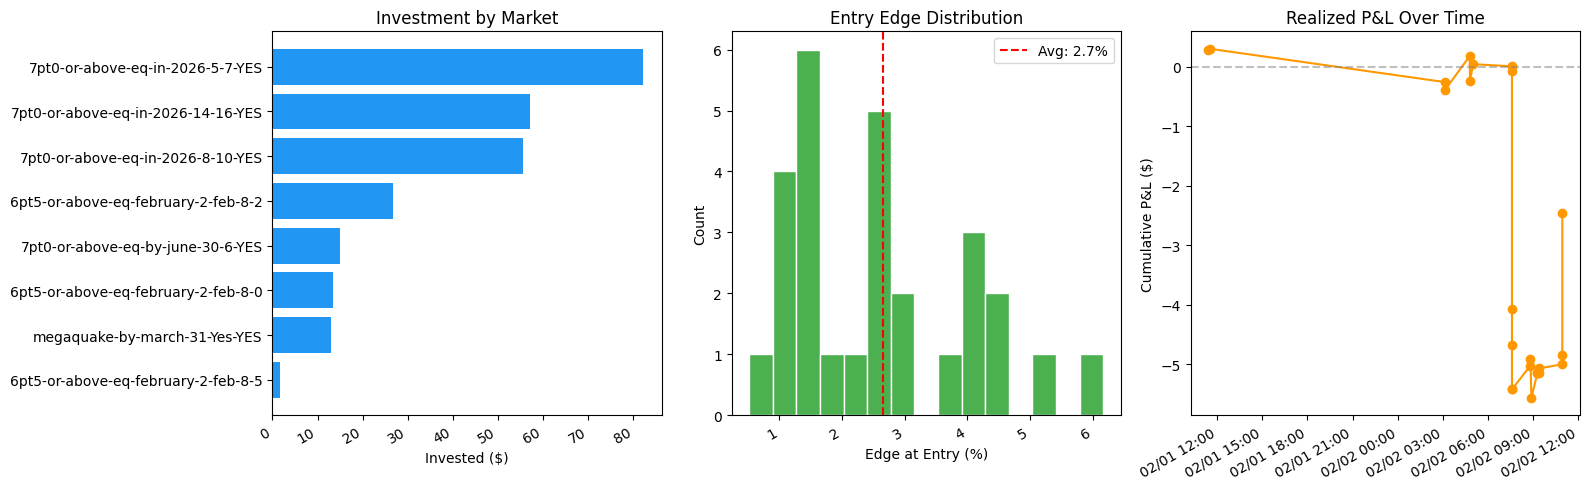

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Investment by market
market_costs = {}
for p in active:
    short = p['market_slug'].replace('how-many-', '').replace('earthquakes-', 'eq-')[:35]
    market_costs[short] = market_costs.get(short, 0) + p['entry_size']

sorted_markets = sorted(market_costs.items(), key=lambda x: x[1], reverse=True)
labels = [m[0] for m in sorted_markets]
values = [m[1] for m in sorted_markets]

axes[0].barh(labels, values, color='#2196F3')
axes[0].set_xlabel('Invested ($)')
axes[0].set_title('Investment by Market')
axes[0].invert_yaxis()

# 2. Entry edge distribution
edges = [p['edge_at_entry'] * 100 for p in active]
axes[1].hist(edges, bins=15, color='#4CAF50', edgecolor='white')
axes[1].set_xlabel('Edge at Entry (%)')
axes[1].set_ylabel('Count')
axes[1].set_title('Entry Edge Distribution')
axes[1].axvline(x=sum(edges)/len(edges), color='red', linestyle='--', label=f'Avg: {sum(edges)/len(edges):.1f}%')
axes[1].legend()

# 3. Cumulative P&L from closed trades
if closed:
    closed_sorted = sorted(closed, key=lambda p: p.get('exit_time', '') or '')
    cum_pnl = []
    dates = []
    running = 0
    for p in closed_sorted:
        exit_size = p.get('exit_size') or 0
        status = p.get('status', 'closed')
        if status == 'win':
            pnl = p['tokens'] - p['entry_size']
        elif status == 'loss':
            pnl = -p['entry_size']
        else:
            pnl = exit_size - p['entry_size']
        running += pnl
        cum_pnl.append(running)
        dt = p.get('exit_time', '') or p['entry_time']
        dates.append(datetime.fromisoformat(dt.replace('Z', '+00:00')))
    axes[2].plot(dates, cum_pnl, 'o-', color='#FF9800', markersize=6)
    axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[2].set_ylabel('Cumulative P&L ($)')
    axes[2].set_title('Realized P&L Over Time')
    axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    fig.autofmt_xdate()
else:
    axes[2].text(0.5, 0.5, 'No closed trades yet', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Realized P&L Over Time')

plt.tight_layout()
plt.show()

## Timeline — All Trades

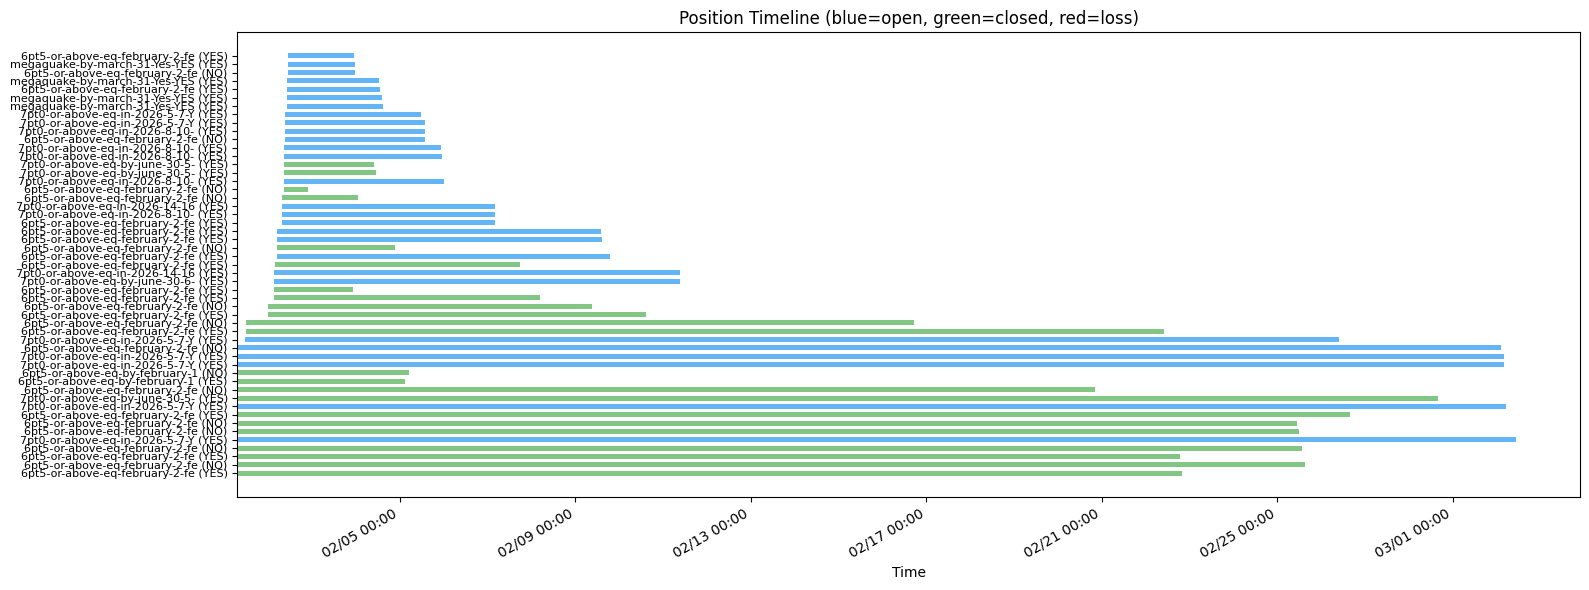

In [5]:
fig, ax = plt.subplots(figsize=(16, 6))

all_sorted = sorted(all_positions, key=lambda p: p['entry_time'])

for i, p in enumerate(all_sorted):
    entry_dt = datetime.fromisoformat(p['entry_time'].replace('Z', '+00:00'))
    status = p.get('status', 'open')

    if status == 'open':
        # Open position — show as arrow to now
        ax.barh(i, (datetime.now(entry_dt.tzinfo) - entry_dt).total_seconds() / 3600,
                left=entry_dt, height=0.6, color='#2196F3', alpha=0.7)
    else:
        exit_dt = datetime.fromisoformat((p.get('exit_time') or p['entry_time']).replace('Z', '+00:00'))
        color = '#4CAF50' if status in ('closed', 'win') else '#F44336'
        ax.barh(i, (exit_dt - entry_dt).total_seconds() / 3600,
                left=entry_dt, height=0.6, color=color, alpha=0.7)

labels = []
for p in all_sorted:
    short = p['market_slug'].replace('how-many-', '').replace('earthquakes-', 'eq-')[:30]
    labels.append(f"{short} ({p['outcome']})")

ax.set_yticks(range(len(all_sorted)))
ax.set_yticklabels(labels, fontsize=8)
ax.set_xlabel('Time')
ax.set_title('Position Timeline (blue=open, green=closed, red=loss)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Summary

In [6]:
total_invested = sum(p['entry_size'] for p in active)
realized_pnl = 0
for p in closed:
    exit_size = p.get('exit_size') or 0
    status = p.get('status', 'closed')
    if status == 'win':
        realized_pnl += p['tokens'] - p['entry_size']
    elif status == 'loss':
        realized_pnl -= p['entry_size']
    else:
        realized_pnl += exit_size - p['entry_size']

avg_edge = sum(p['edge_at_entry'] for p in active) / len(active) if active else 0
avg_entry = sum(p['entry_size'] for p in active) / len(active) if active else 0

print('=' * 50)
print(f'  Open positions:     {len(active)}')
print(f'  Closed positions:   {len(closed)}')
print(f'  Total invested:     ${total_invested:.2f}')
print(f'  Realized P&L:       ${realized_pnl:+.2f}')
print(f'  Avg position size:  ${avg_entry:.2f}')
print(f'  Avg edge at entry:  {avg_edge:.2%}')
print(f'  Sell orders active: {len(sell_orders)}')
print('=' * 50)

  Open positions:     28
  Closed positions:   23
  Total invested:     $264.55
  Realized P&L:       $-2.46
  Avg position size:  $9.45
  Avg edge at entry:  2.65%
  Sell orders active: 29
